In [1]:
%pip install torch torchvision matplotlib scikit-learn tqdm


Note: you may need to restart the kernel to use updated packages.


In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
from pathlib import Path

In [10]:
# ========= 1) Paths =========
DATA_DIR = Path('/Users/aishwarysinghrathour/Desk/Data Sets/Kidney Dataset')  # <-- change this
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42


In [11]:
# ========= 2) Load Dataset =========
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR / "train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR / "valid",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR / "test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

Found 8712 files belonging to 4 classes.
Found 1867 files belonging to 4 classes.
Found 1867 files belonging to 4 classes.
Classes: ['Cyst', 'Normal', 'Stone', 'Tumor']


In [13]:
# ========= 3) Dataset Counts =========
def count_per_class(dataset):
    counter = collections.Counter()
    for _, labels in dataset.unbatch():
        counter[int(labels.numpy())] += 1
    return counter

print("\nTrain set:", count_per_class(train_ds))
print("Valid set:", count_per_class(val_ds))
print("Test  set:", count_per_class(test_ds))


2025-08-22 15:36:19.560825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Train set: Counter({1: 3553, 0: 2597, 3: 1599, 2: 963})


2025-08-22 15:36:21.632373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Valid set: Counter({1: 762, 0: 556, 3: 342, 2: 207})
Test  set: Counter({1: 762, 0: 556, 3: 342, 2: 207})


2025-08-22 15:36:23.625571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
# ========= 4) Data Pipeline =========
AUTOTUNE = tf.data.AUTOTUNE

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Normalize images
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                        num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y), 
                        num_parallel_calls=AUTOTUNE)
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y), 
                        num_parallel_calls=AUTOTUNE)
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y), 
                        num_parallel_calls=AUTOTUNE)

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

In [15]:
# ========= 5) Model =========
from tensorflow.keras import layers, models, regularizers

def build_model(input_shape=(224,224,3), num_classes=4):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation="relu", padding="same",
                      kernel_regularizer=regularizers.l2(1e-4),
                      input_shape=input_shape),
        layers.MaxPooling2D(),
        
        layers.Conv2D(64, (3,3), activation="relu", padding="same",
                      kernel_regularizer=regularizers.l2(1e-4)),
        layers.MaxPooling2D(),
        
        layers.Conv2D(128, (3,3), activation="relu", padding="same",
                      kernel_regularizer=regularizers.l2(1e-4)),
        layers.MaxPooling2D(),
        
        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])
    return model

model = build_model(input_shape=(224,224,3), num_classes=num_classes)


/opt/anaconda3/envs/tf_env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# ========= 6) Compile =========
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [17]:
# ========= 7) Training =========
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 145s 508ms/step - accuracy: 0.5924 - loss: 1.0385 - val_accuracy: 0.6352 - val_loss: 0.9487 - learning_rate: 1.0000e-04
Epoch 2/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 158s 576ms/step - accuracy: 0.6707 - loss: 0.9679 - val_accuracy: 0.5640 - val_loss: 2.0925 - learning_rate: 1.0000e-04
Epoch 3/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 125s 455ms/step - accuracy: 0.6926 - loss: 1.4313 - val_accuracy: 0.4135 - val_loss: 3.5481 - learning_rate: 1.0000e-04
Epoch 4/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 122s 444ms/step - accuracy: 0.6779 - loss: 3.5810 - val_accuracy: 0.4049 - val_loss: 7.8758 - learning_rate: 1.0000e-04
Epoch 5/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 123s 446ms/step - accuracy: 0.6576 - loss: 10.4145 - val_accuracy: 0.4671 - val_loss: 15.7185 - learning_rate: 5.0000e-05
Epoch 6/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 125s 456ms/step - accuracy: 0.6614 - loss: 23.2492 - val_accuracy: 0.5710 - val_loss: 27.2024 - learning_rate: 5.0000e-05


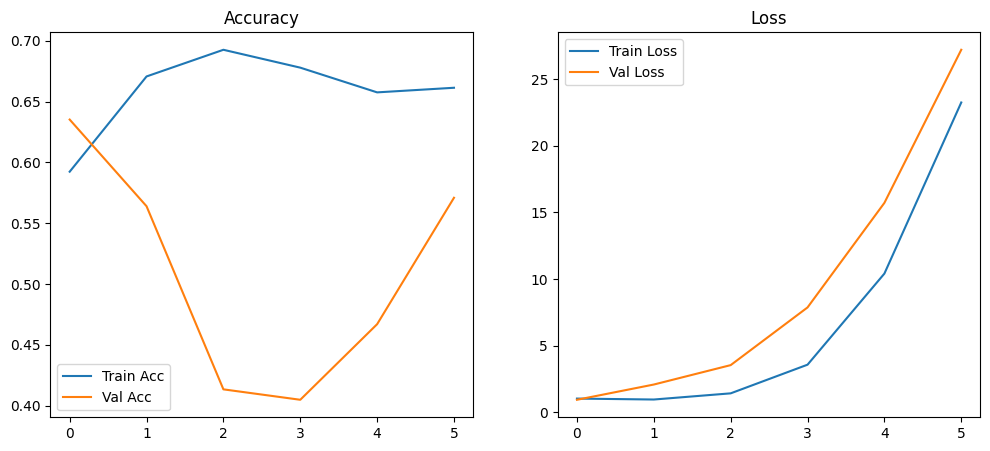

In [18]:
# ========= 8) Plot Training =========
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.show()


In [19]:
# ========= 9) Evaluate =========
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.6551 - loss: 0.9720

Test Accuracy: 0.6551, Test Loss: 0.9720


## Training With Pretrained Model - Xception

In [31]:
import os, random, itertools, collections
from pathlib import Path

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import matplotlib.pyplot as plt

# (optional) for metrics
try:
    from sklearn.metrics import confusion_matrix, classification_report
    SKLEARN_OK = True
except Exception:
    SKLEARN_OK = False


In [32]:
DATA_DIR = Path("/Users/aishwarysinghrathour/Desk/Data Sets/Kidney Dataset")  

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
EPOCHS_STAGE1 = 10     # train head with base frozen
EPOCHS_STAGE2 = 10     # fine-tune some base layers
AUGMENT = True

tf.keras.utils.set_random_seed(SEED)

# GPU memory growth (safe default)
for g in tf.config.list_physical_devices('GPU'):
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except:
        pass

In [33]:
# 1) Load datasets (RGB) 
#    -> this avoids grayscale_to_rgb errors
# -------------------------
def make_ds(split, shuffle):
    return tf.keras.utils.image_dataset_from_directory(
        DATA_DIR / split,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        color_mode="rgb"   # force 3 channels
    )

raw_train_ds = make_ds("train", shuffle=True)
raw_val_ds   = make_ds("valid", shuffle=False)
raw_test_ds  = make_ds("test",  shuffle=False)

class_names = raw_train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)


Found 8712 files belonging to 4 classes.
Found 1867 files belonging to 4 classes.
Found 1867 files belonging to 4 classes.
Classes: ['Cyst', 'Normal', 'Stone', 'Tumor']


In [34]:
# 2) Dataset counts (split + per class)
# -------------------------
def count_split(ds):
    n = 0
    for _, y in ds.unbatch():
        n += 1
    return n

def count_per_class(ds, class_names):
    counter = collections.Counter()
    for _, y in ds.unbatch():
        counter[int(y.numpy())] += 1
    return {class_names[i]: counter[i] for i in range(len(class_names))}

print("\n=== Dataset Summary ===")
n_train = count_split(raw_train_ds)
n_val   = count_split(raw_val_ds)
n_test  = count_split(raw_test_ds)
print(f"Train images: {n_train}")
print(f"Valid images: {n_val}")
print(f"Test  images: {n_test}")
print(f"Total images: {n_train + n_val + n_test}")

print("\nPer-class (Train):", count_per_class(raw_train_ds, class_names))
print("Per-class (Valid):", count_per_class(raw_val_ds, class_names))
print("Per-class (Test) :", count_per_class(raw_test_ds, class_names))



=== Dataset Summary ===


2025-08-22 19:43:24.518563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-22 19:43:26.666048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-22 19:43:28.633020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train images: 8712
Valid images: 1867
Test  images: 1867
Total images: 12446


2025-08-22 19:43:38.775989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Per-class (Train): {'Cyst': 2597, 'Normal': 3553, 'Stone': 963, 'Tumor': 1599}


2025-08-22 19:43:40.857497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Per-class (Valid): {'Cyst': 556, 'Normal': 762, 'Stone': 207, 'Tumor': 342}
Per-class (Test) : {'Cyst': 556, 'Normal': 762, 'Stone': 207, 'Tumor': 342}


2025-08-22 19:43:43.303441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [35]:
# 3) Pipeline: Augmentation + preprocess_input + prefetch
# -------------------------
AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
], name="augmentation")

def prep_train(x, y):
    if AUGMENT:
        x = data_augmentation(x, training=True)
    # EfficientNet preprocess (expects RGB in [0..255])
    x = applications.efficientnet.preprocess_input(x)
    return x, y

def prep_eval(x, y):
    x = applications.efficientnet.preprocess_input(x)
    return x, y

train_ds = raw_train_ds.map(prep_train, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds   = raw_val_ds.map(prep_eval,   num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
test_ds  = raw_test_ds.map(prep_eval,  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

In [36]:
# 4) Class weights (helps with imbalance)
# -------------------------
train_labels = [int(y.numpy()) for _, y in raw_train_ds.unbatch()]
counts = np.bincount(train_labels, minlength=num_classes).astype(np.float32)
weights = {i: (len(train_labels) / (num_classes * counts[i])) if counts[i] > 0 else 1.0
           for i in range(num_classes)}
print("\nClass weights:", weights)



Class weights: {0: 0.8386599922988063, 1: 0.6130030959752322, 2: 2.2616822429906542, 3: 1.3621013133208255}


2025-08-22 19:46:48.705026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [42]:
# -------------------------
# 5) Build model (Change backbone here)
# -------------------------
def build_model(input_shape=(224,224,3), num_classes=4, dropout=0.4, backbone="Xception"):
    if backbone == "Xception":
        base = applications.Xception(include_top=False, weights="imagenet", input_shape=input_shape)
    elif backbone == "InceptionV3":
        base = applications.InceptionV3(include_top=False, weights="imagenet", input_shape=input_shape)
    elif backbone == "MobileNetV2":
        base = applications.MobileNetV2(include_top=False, weights="imagenet", input_shape=input_shape)
    elif backbone == "MobileNetV3Large":
        base = applications.MobileNetV3Large(include_top=False, weights="imagenet", input_shape=input_shape)
    elif backbone == "NASNetMobile":
        base = applications.NASNetMobile(include_top=False, weights="imagenet", input_shape=input_shape)
    elif backbone == "VGG16":
        base = applications.VGG16(include_top=False, weights="imagenet", input_shape=input_shape)
    elif backbone == "VGG19":
        base = applications.VGG19(include_top=False, weights="imagenet", input_shape=input_shape)
    else:
        raise ValueError(f"Unknown backbone: {backbone}")

    base.trainable = False  # Stage 1: freeze

    inputs = layers.Input(shape=input_shape)
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs, name=f"{backbone}_transfer")
    return model, base

# pick your backbone here:
# Options: "Xception", "InceptionV3", "MobileNetV2", "MobileNetV3Large", "NASNetMobile", "VGG16", "VGG19"
model, base_model = build_model(
    input_shape=(*IMG_SIZE,3),
    num_classes=num_classes,
    dropout=0.4,
    backbone="Xception"   # 👈 change this string to try different models
)
# Compile the model BEFORE training
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)



In [43]:
print("\n=== Stage 1: Train head (base frozen) ===")
hist1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE1,
    class_weight=weights,
    callbacks=callbacks,
    verbose=1
)



=== Stage 1: Train head (base frozen) ===
Epoch 1/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - accuracy: 0.3255 - loss: 3.9948 - val_accuracy: 0.4553 - val_loss: 2.2515 - learning_rate: 1.0000e-04
Epoch 2/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 374s 1s/step - accuracy: 0.3868 - loss: 3.0322 - val_accuracy: 0.4746 - val_loss: 2.3172 - learning_rate: 1.0000e-04
Epoch 3/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - accuracy: 0.4151 - loss: 2.5339 - val_accuracy: 0.5046 - val_loss: 2.1769 - learning_rate: 1.0000e-04
Epoch 4/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 423s 2s/step - accuracy: 0.4385 - loss: 2.1349 - val_accuracy: 0.5281 - val_loss: 2.3341 - learning_rate: 1.0000e-04
Epoch 5/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 385s 1s/step - accuracy: 0.4681 - loss: 1.9004 - val_accuracy: 0.5453 - val_loss: 2.2406 - learning_rate: 1.0000e-04
Epoch 6/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - accuracy: 0.4831 - loss: 1.7261 - val_accuracy: 0.5854 - val_loss: 2.0866 - learning_rate: 1.0000e-04
Epoch 7/10
273/

In [44]:
# 6) Fine-tune (unfreeze top layers, small LR)
# -------------------------
base_model.trainable = True
freeze_until = len(base_model.layers) // 2   # keep lower half frozen
for l in base_model.layers[:freeze_until]:
    l.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("\n=== Stage 2: Fine-tune (partial unfreeze) ===")
hist2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE2,
    class_weight=weights,
    callbacks=callbacks,
    verbose=1
)


=== Stage 2: Fine-tune (partial unfreeze) ===
Epoch 1/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 608s 2s/step - accuracy: 0.5201 - loss: 1.2093 - val_accuracy: 0.7001 - val_loss: 0.8511 - learning_rate: 1.0000e-05
Epoch 2/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 633s 2s/step - accuracy: 0.6343 - loss: 1.0268 - val_accuracy: 0.6593 - val_loss: 0.7827 - learning_rate: 1.0000e-05
Epoch 3/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 642s 2s/step - accuracy: 0.6764 - loss: 0.9244 - val_accuracy: 0.6577 - val_loss: 0.7255 - learning_rate: 1.0000e-05
Epoch 4/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 665s 2s/step - accuracy: 0.7033 - loss: 0.8219 - val_accuracy: 0.7070 - val_loss: 0.7340 - learning_rate: 1.0000e-05
Epoch 5/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 694s 3s/step - accuracy: 0.7296 - loss: 0.7616 - val_accuracy: 0.7584 - val_loss: 0.6814 - learning_rate: 1.0000e-05
Epoch 6/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 588s 2s/step - accuracy: 0.7478 - loss: 0.6968 - val_accuracy: 0.6668 - val_loss: 0.7233 - learning_rate: 1.0000e-05
Epoch 7/10


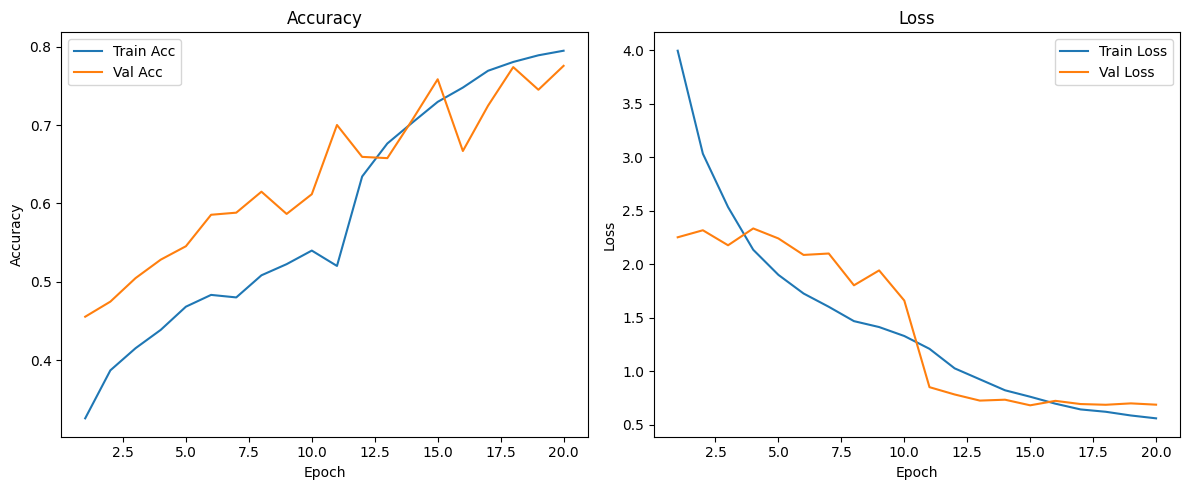

In [45]:
# 7) Plot training curves
# -------------------------
def plot_history(histories):
    acc = []; val_acc = []; loss = []; val_loss = []
    for h in histories:
        acc     += h.history.get("accuracy", [])
        val_acc += h.history.get("val_accuracy", [])
        loss    += h.history.get("loss", [])
        val_loss+= h.history.get("val_loss", [])
    epochs_range = range(1, len(acc)+1)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="Train Acc")
    plt.plot(epochs_range, val_acc, label="Val Acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="Train Loss")
    plt.plot(epochs_range, val_loss, label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss"); plt.legend()
    plt.tight_layout(); plt.show()

plot_history([hist1, hist2])

59/59 ━━━━━━━━━━━━━━━━━━━━ 35s 592ms/step - accuracy: 0.5870 - loss: 1.1976

[Test] Loss=1.1976, Acc=0.5870

Classification report:
              precision    recall  f1-score   support

        Cyst     0.8495    0.8022    0.8252       556
      Normal     0.5962    0.7323    0.6572       762
       Stone     0.4184    0.3961    0.4069       207
       Tumor     0.0476    0.0292    0.0362       342

    accuracy                         0.5870      1867
   macro avg     0.4779    0.4900    0.4814      1867
weighted avg     0.5514    0.5870    0.5657      1867



2025-08-22 22:55:17.198306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


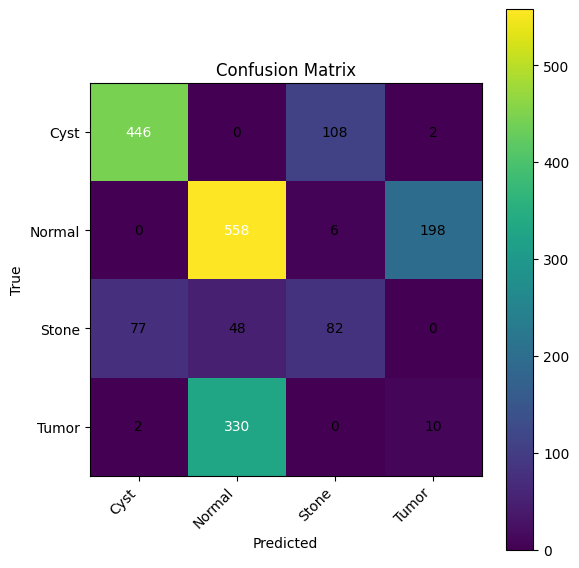

In [46]:
# 8) Evaluate on test set
# -------------------------
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"\n[Test] Loss={test_loss:.4f}, Acc={test_acc:.4f}")

# Detailed metrics
if SKLEARN_OK:
    y_true, y_pred = [], []
    for xb, yb in test_ds:
        probs = model.predict(xb, verbose=0)
        y_true.extend(yb.numpy().tolist())
        y_pred.extend(np.argmax(probs, axis=1).tolist())
    y_true = np.array(y_true); y_pred = np.array(y_pred)

    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix")
    plt.colorbar()
    ticks = np.arange(num_classes)
    plt.xticks(ticks, class_names, rotation=45, ha="right"); plt.yticks(ticks, class_names)
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel("True"); plt.xlabel("Predicted"); plt.tight_layout(); plt.show()


2025-08-22 22:58:54.352041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


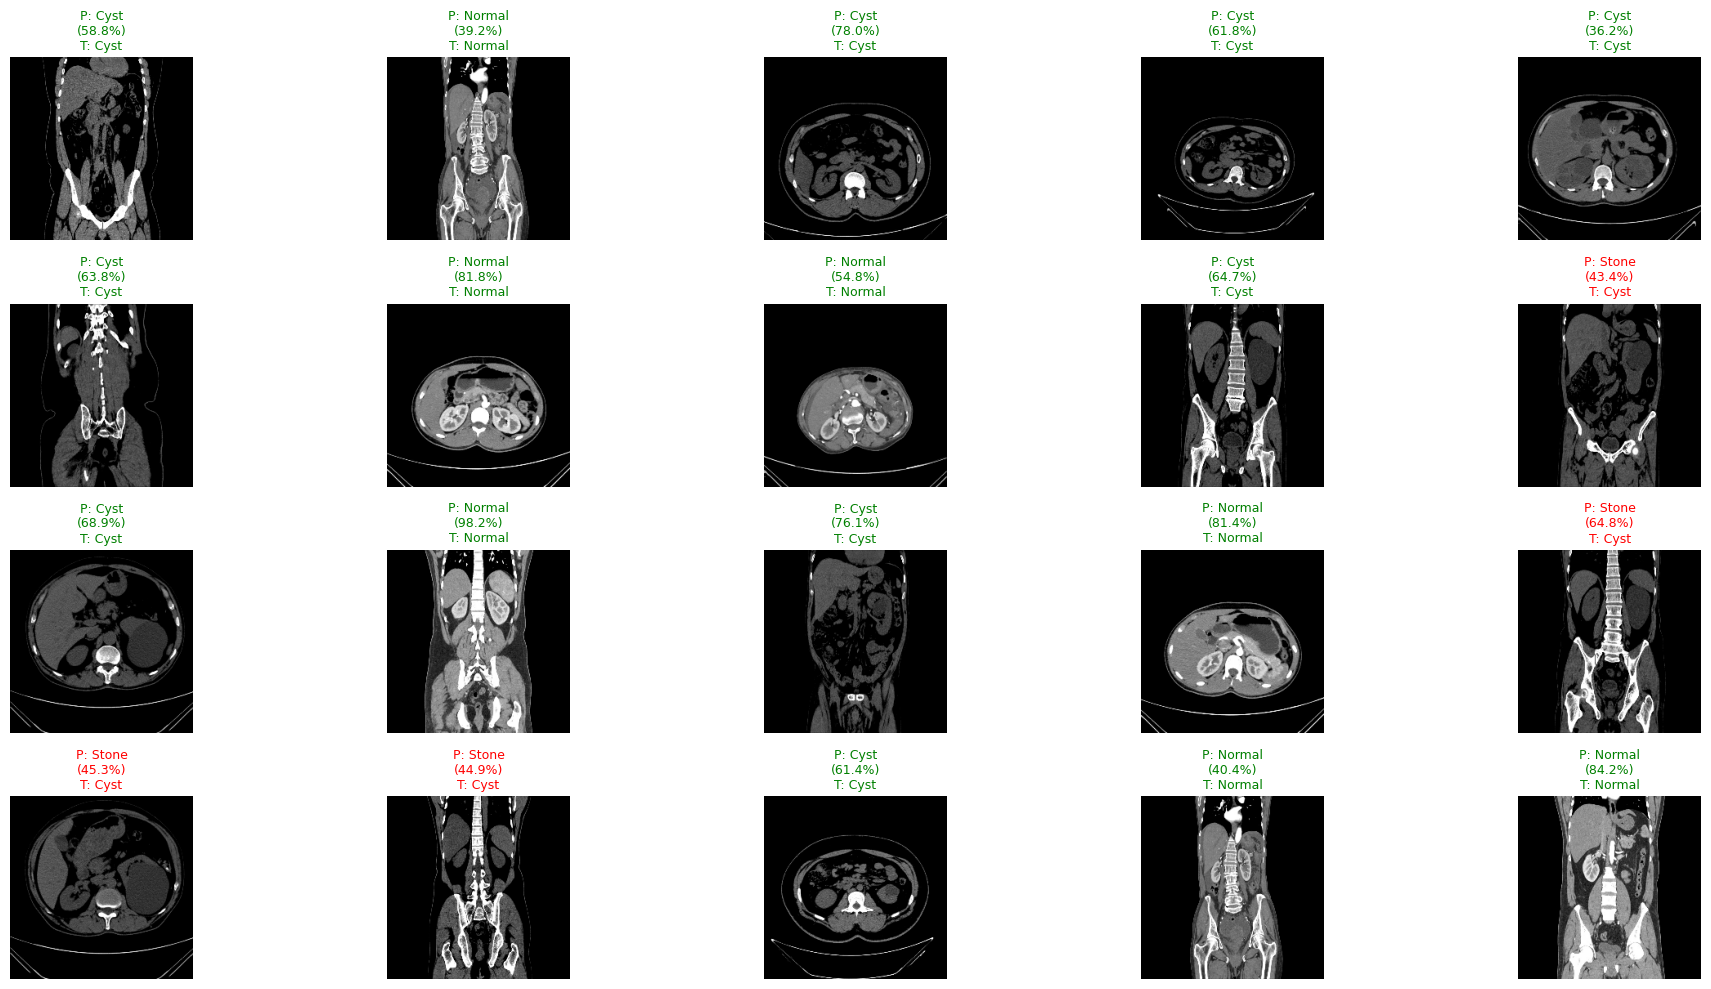

In [49]:
# -------------------------
# 9) Multiple random predictions across the whole test set
# -------------------------
n_samples = 20   # 👈 how many images you want to display

# Unbatch and shuffle the test dataset
test_images = []
test_labels = []
for img, lbl in raw_test_ds.unbatch().shuffle(1000).take(n_samples):
    test_images.append(img.numpy().astype("uint8"))
    test_labels.append(int(lbl.numpy()))

plt.figure(figsize=(20, 10))
for i in range(n_samples):
    img_disp = test_images[i]
    true_idx = test_labels[i]
    true_label = class_names[true_idx]

    # preprocess same way as pipeline
    img_in = tf.expand_dims(img_disp, 0)  # (1,H,W,3)
    img_in = applications.efficientnet.preprocess_input(img_in)
    probs = model.predict(img_in, verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    pred_label = class_names[pred_idx]
    pred_prob = float(probs[pred_idx])

    # subplot grid (5x4 if 20 images)
    plt.subplot(4, 5, i+1)
    plt.imshow(img_disp)
    plt.axis("off")

    # ✅ color title green if correct, red if wrong
    color = "green" if pred_idx == true_idx else "red"
    plt.title(f"P: {pred_label}\n({pred_prob:.1%})\nT: {true_label}", 
              fontsize=9, color=color)

plt.tight_layout()
plt.show()


## Training With Pretrained Model - InceptionV3

In [50]:
# -------------------------
# 5) Build model (Change backbone here)
# -------------------------
def build_model(input_shape=(224,224,3), num_classes=4, dropout=0.4, backbone="Xception"):
    if backbone == "Xception":
        base = applications.Xception(include_top=False, weights="imagenet", input_shape=input_shape)
    elif backbone == "InceptionV3":
        base = applications.InceptionV3(include_top=False, weights="imagenet", input_shape=input_shape)
    elif backbone == "MobileNetV2":
        base = applications.MobileNetV2(include_top=False, weights="imagenet", input_shape=input_shape)
    elif backbone == "MobileNetV3Large":
        base = applications.MobileNetV3Large(include_top=False, weights="imagenet", input_shape=input_shape)
    elif backbone == "NASNetMobile":
        base = applications.NASNetMobile(include_top=False, weights="imagenet", input_shape=input_shape)
    elif backbone == "VGG16":
        base = applications.VGG16(include_top=False, weights="imagenet", input_shape=input_shape)
    elif backbone == "VGG19":
        base = applications.VGG19(include_top=False, weights="imagenet", input_shape=input_shape)
    else:
        raise ValueError(f"Unknown backbone: {backbone}")

    base.trainable = False  # Stage 1: freeze

    inputs = layers.Input(shape=input_shape)
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs, name=f"{backbone}_transfer")
    return model, base

# pick your backbone here:
# Options: "Xception", "InceptionV3", "MobileNetV2", "MobileNetV3Large", "NASNetMobile", "VGG16", "VGG19"
model, base_model = build_model(
    input_shape=(*IMG_SIZE,3),
    num_classes=num_classes,
    dropout=0.4,
    backbone="InceptionV3"   
)
# Compile the model BEFORE training
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)



87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


In [51]:
print("\n=== Stage 1: Train head (base frozen) ===")
hist1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE1,
    class_weight=weights,
    callbacks=callbacks,
    verbose=1
)



=== Stage 1: Train head (base frozen) ===
Epoch 1/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 96s 316ms/step - accuracy: 0.3221 - loss: 13.9432 - val_accuracy: 0.5570 - val_loss: 1.8946 - learning_rate: 1.0000e-04
Epoch 2/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 85s 308ms/step - accuracy: 0.3969 - loss: 9.9717 - val_accuracy: 0.6352 - val_loss: 1.6704 - learning_rate: 1.0000e-04
Epoch 3/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 93s 339ms/step - accuracy: 0.4249 - loss: 8.3315 - val_accuracy: 0.6518 - val_loss: 1.7002 - learning_rate: 1.0000e-04
Epoch 4/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 97s 351ms/step - accuracy: 0.4361 - loss: 7.6150 - val_accuracy: 0.6229 - val_loss: 1.5708 - learning_rate: 5.0000e-05
Epoch 5/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 109s 396ms/step - accuracy: 0.4508 - loss: 6.7281 - val_accuracy: 0.6492 - val_loss: 1.5503 - learning_rate: 5.0000e-05


In [52]:
# 6) Fine-tune (unfreeze top layers, small LR)
# -------------------------
base_model.trainable = True
freeze_until = len(base_model.layers) // 2   # keep lower half frozen
for l in base_model.layers[:freeze_until]:
    l.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("\n=== Stage 2: Fine-tune (partial unfreeze) ===")
hist2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=weights,
    callbacks=callbacks,
    verbose=1
)


=== Stage 2: Fine-tune (partial unfreeze) ===
Epoch 1/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 394s 1s/step - accuracy: 0.5505 - loss: 1.1917 - val_accuracy: 0.6604 - val_loss: 0.7947 - learning_rate: 1.0000e-05
Epoch 2/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 335s 1s/step - accuracy: 0.7121 - loss: 0.7724 - val_accuracy: 0.6588 - val_loss: 0.8048 - learning_rate: 1.0000e-05
Epoch 3/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - accuracy: 0.7815 - loss: 0.5927 - val_accuracy: 0.6513 - val_loss: 0.8384 - learning_rate: 1.0000e-05
Epoch 4/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 373s 1s/step - accuracy: 0.8115 - loss: 0.4914 - val_accuracy: 0.6583 - val_loss: 0.8233 - learning_rate: 5.0000e-06
Epoch 5/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 430s 2s/step - accuracy: 0.8370 - loss: 0.4390 - val_accuracy: 0.6615 - val_loss: 0.8165 - learning_rate: 5.0000e-06


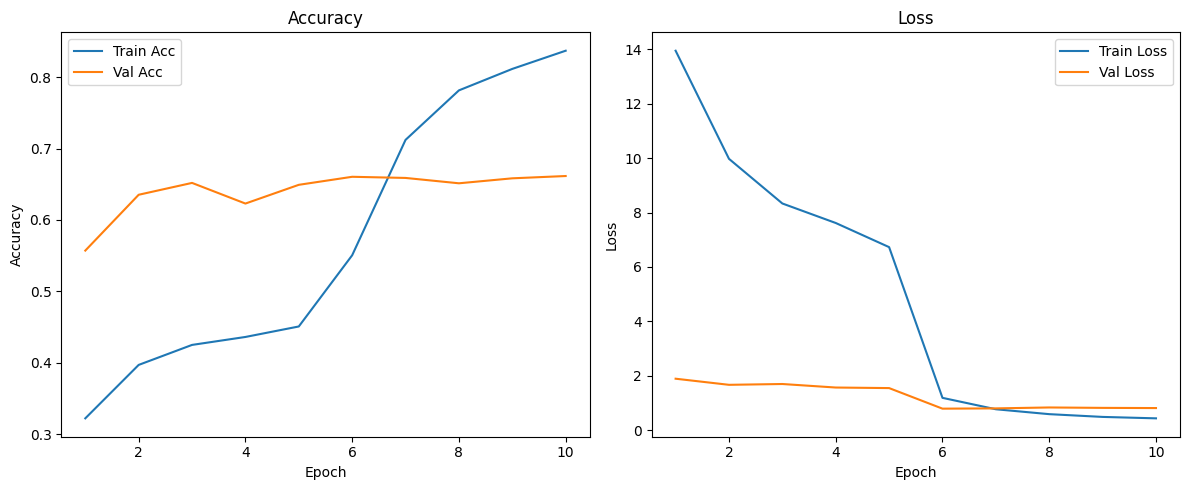

In [53]:
# 7) Plot training curves
# -------------------------
def plot_history(histories):
    acc = []; val_acc = []; loss = []; val_loss = []
    for h in histories:
        acc     += h.history.get("accuracy", [])
        val_acc += h.history.get("val_accuracy", [])
        loss    += h.history.get("loss", [])
        val_loss+= h.history.get("val_loss", [])
    epochs_range = range(1, len(acc)+1)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="Train Acc")
    plt.plot(epochs_range, val_acc, label="Val Acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="Train Loss")
    plt.plot(epochs_range, val_loss, label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss"); plt.legend()
    plt.tight_layout(); plt.show()

plot_history([hist1, hist2])

59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 238ms/step - accuracy: 0.6181 - loss: 1.0576

[Test] Loss=1.0576, Acc=0.6181


2025-08-22 23:49:03.935349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Classification report:
              precision    recall  f1-score   support

        Cyst     0.8711    0.7050    0.7793       556
      Normal     0.6611    0.8268    0.7347       762
       Stone     0.3531    0.4879    0.4097       207
       Tumor     0.1742    0.0906    0.1192       342

    accuracy                         0.6181      1867
   macro avg     0.5149    0.5276    0.5107      1867
weighted avg     0.6003    0.6181    0.5992      1867



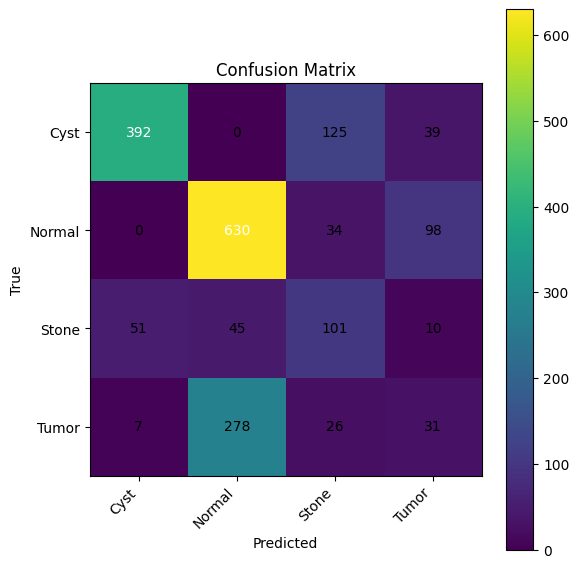

In [54]:
# 8) Evaluate on test set
# -------------------------
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"\n[Test] Loss={test_loss:.4f}, Acc={test_acc:.4f}")

# Detailed metrics
if SKLEARN_OK:
    y_true, y_pred = [], []
    for xb, yb in test_ds:
        probs = model.predict(xb, verbose=0)
        y_true.extend(yb.numpy().tolist())
        y_pred.extend(np.argmax(probs, axis=1).tolist())
    y_true = np.array(y_true); y_pred = np.array(y_pred)

    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix")
    plt.colorbar()
    ticks = np.arange(num_classes)
    plt.xticks(ticks, class_names, rotation=45, ha="right"); plt.yticks(ticks, class_names)
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel("True"); plt.xlabel("Predicted"); plt.tight_layout(); plt.show()


2025-08-22 23:50:49.164535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


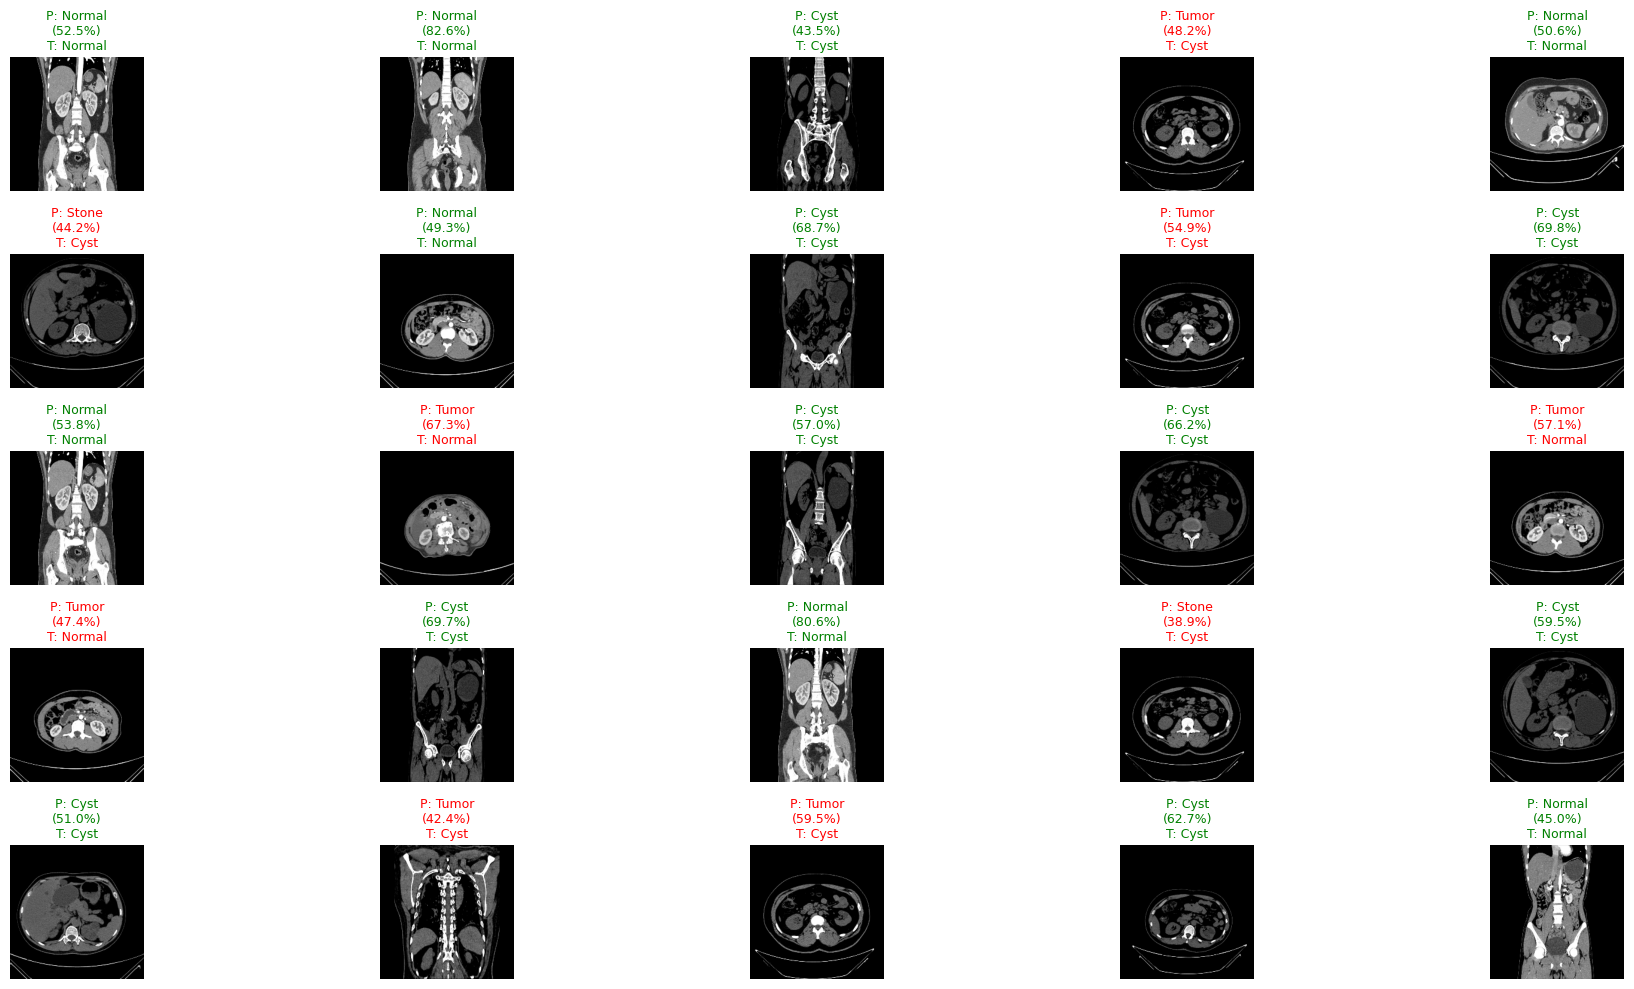

In [58]:
# -------------------------
# 9) Multiple random predictions across the whole test set
# -------------------------
n_samples = 25   # 👈 how many images you want to display

# Unbatch and shuffle the test dataset
test_images = []
test_labels = []
for img, lbl in raw_test_ds.unbatch().shuffle(1000).take(n_samples):
    test_images.append(img.numpy().astype("uint8"))
    test_labels.append(int(lbl.numpy()))

plt.figure(figsize=(20, 10))
for i in range(n_samples):
    img_disp = test_images[i]
    true_idx = test_labels[i]
    true_label = class_names[true_idx]

    # preprocess same way as pipeline
    img_in = tf.expand_dims(img_disp, 0)  # (1,H,W,3)
    img_in = applications.efficientnet.preprocess_input(img_in)
    probs = model.predict(img_in, verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    pred_label = class_names[pred_idx]
    pred_prob = float(probs[pred_idx])

    # subplot grid (5x4 if 20 images)
    plt.subplot(5, 5, i+1)
    plt.imshow(img_disp)
    plt.axis("off")

    # ✅ color title green if correct, red if wrong
    color = "green" if pred_idx == true_idx else "red"
    plt.title(f"P: {pred_label}\n({pred_prob:.1%})\nT: {true_label}", 
              fontsize=9, color=color)

plt.tight_layout()
plt.show()
